In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as db 
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect
from flask import Flask, jsonify

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Precipitation Analysis

In [13]:
table = engine.execute('SELECT date, prcp FROM measurement WHERE date >= "2016-08-23"').fetchall()

In [14]:
measurement_df = pd.DataFrame(table)
measurement_df.head()
measurement_df.columns = ['Date', 'PRCP']
measurement_df.head()

,Date,PRCP
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [15]:
measurement_df_drop = measurement_df.dropna()
date_measure = measurement_df_drop['Date']
prcp_measure = measurement_df_drop['PRCP']
final_measure_df = measurement_df_drop.set_index('Date')

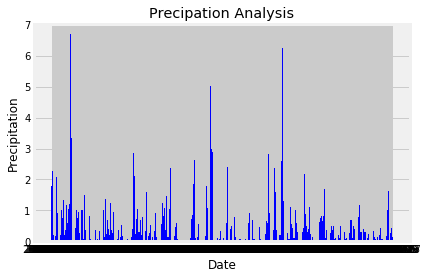

In [16]:
plt.title("Precipation Analysis")
plt.xlabel("Date")
plt.ylabel("Precipitation")

plt.bar(date_measure, prcp_measure, facecolor="blue", alpha=2.0, align="center")
plt.show()

In [17]:
measurement_df_drop.describe()

,PRCP
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [18]:
value = engine.execute('SELECT station tobs FROM station COUNT').fetchall()
value

[('USC00519397',),
 ('USC00513117',),
 ('USC00514830',),
 ('USC00517948',),
 ('USC00518838',),
 ('USC00519523',),
 ('USC00519281',),
 ('USC00511918',),
 ('USC00516128',)]

In [19]:
table1 = engine.execute('SELECT station, COUNT(tobs) FROM measurement GROUP BY station ORDER BY tobs DESC').fetchall()
stations_df = pd.DataFrame(table1)
stations_df.columns = (['Station','Totals'])
stations_df.sort_values(by='Totals', ascending=False)

,Station,Totals
4,USC00519281,2772
8,USC00519397,2724
5,USC00513117,2709
1,USC00519523,2669
2,USC00516128,2612
6,USC00514830,2202
7,USC00511918,1979
0,USC00517948,1372
3,USC00518838,511


In [20]:
table_station = engine.execute('SELECT * FROM station').fetchall()
table_measurement = engine.execute('SELECT * FROM measurement WHERE date >= "2016-08-23"').fetchall()
df_station = pd.DataFrame(table_station)
df_measurement = pd.DataFrame(table_measurement)
df_measurement.columns = (['Index','Station','Date','PCP','Tobs'])
df_station.columns = (['Index','Station','Name','Latitude',
                       'Longitude','Elevation'])
df_merged = pd.merge(df_station, df_measurement, on='Station')
df_merged.head()

,Index_x,Station,Name,Latitude,Longitude,Elevation,Index_y,Date,PCP,Tobs
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2364,2016-08-23,0.00,81.0
1,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2365,2016-08-24,0.08,79.0
2,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2366,2016-08-25,0.08,80.0
3,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2367,2016-08-26,0.00,79.0
4,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2368,2016-08-27,0.00,77.0


In [21]:
table_merge = engine.execute('SELECT s.station,m.Tobs, m.Date FROM measurement AS m INNER JOIN station AS s ON s.station=m.station WHERE date >= "2016-08-23"').fetchall()
df_table_merge = pd.DataFrame(table_merge)
df_table_merge.columns = ['Station','Tobs', 'Date']
df_final = df_table_merge.loc[df_table_merge["Station"] == "USC00519281",:] 
df_final.head()

,Station,Tobs,Date
1529,USC00519281,77.0,2016-08-23
1530,USC00519281,77.0,2016-08-24
1531,USC00519281,80.0,2016-08-25
1532,USC00519281,80.0,2016-08-26
1533,USC00519281,75.0,2016-08-27


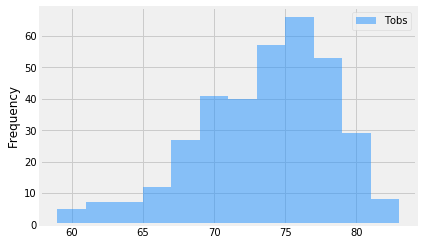

In [22]:
graph = df_final.plot.hist(bins=12, alpha=0.5, facecolor="dodgerblue")

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-02-28', '2017-03-05'))

[(59.0, 74.11674478057094, 84.0)]


<BarContainer object of 1 artists>

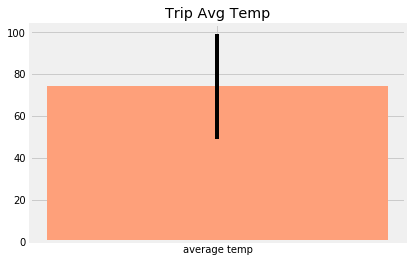

In [25]:
plt.title("Trip Avg Temp")

avg_temp = 74.11674478057094
label = "average temp"
plt.bar(label, avg_temp, width=0.5, yerr=(84-59), facecolor="lightsalmon", alpha=2.0, align="center")

# Climate App

In [26]:
# Flask Setup
app = Flask(__name__)
# Flask Routes
@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"- List of prior year rain totals from all stations<br/>"
        f"<br/>"
        f"/api/v1.0/stations<br/>"
        f"- List of Station numbers and names<br/>"
        f"<br/>"
        f"/api/v1.0/tobs<br/>"
        f"- List of prior year temperatures from all stations<br/>"
        f"<br/>"
        f"/api/v1.0/start<br/>"
        f"- When given the start date (YYYY-MM-DD), calculates the MIN/AVG/MAX temperature for all dates greater than and equal to the start date<br/>"
        f"<br/>"
        f"/api/v1.0/start/end<br/>"
        f"- When given the start and the end date (YYYY-MM-DD), calculate the MIN/AVG/MAX temperature for dates between the start and end date inclusive<br/>"
    )

In [27]:
# Flask Setup
app = Flask(__name__)
#Home page.
#List all routes that are available.
@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/station"
        f"/api/v1.0/prcp"
        f"/api/v1.0/date"
        f"/api/v1.0/tobs"
    )

In [28]:
#Convert the query results to a Dictionary using date as the key and prcp as the value.
#Return the JSON representation of your dictionary.
@app.route("/api/v1.0/date")
def date():
    # Create our session (link) from Python to the DB
    session = Session(engine)

    results = session.query(Measurement.tobs).group_by(Measurement.station).all()

    session.close()

    # Convert list of tuples into normal list
    all_dates = list(np.ravel(results))
    return jsonify(all_dates)

In [29]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    """Return a list of rain fall for prior year"""
#    * Query for the dates and precipitation observations from the last year.
#           * Convert the query results to a Dictionary using `date` as the key and `prcp` as the value.
#           * Return the json representation of your dictionary.

    last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
    last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
    rain = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date > last_year).\
        order_by(Measurement.date).all()

# Create a list of dicts with `date` and `prcp` as the keys and values

    rain_totals = []
    for result in rain:
        row = {}
        row["date"] = rain[0]
        row["prcp"] = rain[1]
        rain_totals.append(row)
    return jsonify(rain_totals)

In [30]:
@app.route("/api/v1.0/stations")

def stations():

    stations_query = session.query(Station.name, Station.station)
    stations = pd.read_sql(stations_query.statement, stations_query.session.bind)
    return jsonify(stations.to_dict())

In [31]:
@app.route("/api/v1.0/tobs")

def tobs():

    """Return a list of temperatures for prior year"""

# Query for the dates and temperature observations from the last year.
# Convert the query results to a Dictionary using `date` as the key and `tobs` as the value.
# Return the json representation of your dictionary.

    last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
    last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
    temperature = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date > last_year).\
        order_by(Measurement.date).all()


# Create a list of dicts with `date` and `tobs` as the keys and values

    temperature_totals = []
    for result in temperature:
        row = {}
        row["date"] = temperature[0]
        row["tobs"] = temperature[1]
        temperature_totals.append(row)

    return jsonify(temperature_totals)

In [32]:
@app.route("/api/v1.0/<start>")
def trip1(start):

 # go back one year from start date and go to end of data for Min/Avg/Max temp   

    start_date= dt.datetime.strptime(start, '%Y-%m-%d')
    last_year = dt.timedelta(days=365)
    start = start_date-last_year
    end =  dt.date(2017, 8, 23)
    trip_data = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start).filter(Measurement.date <= end).all()
    trip = list(np.ravel(trip_data))
    return jsonify(trip)

In [33]:
@app.route("/api/v1.0/<start>/<end>")
def trip2(start,end):

  # go back one year from start/end date and get Min/Avg/Max temp     

    start_date= dt.datetime.strptime(start, '%Y-%m-%d')
    end_date= dt.datetime.strptime(end,'%Y-%m-%d')
    last_year = dt.timedelta(days=365)
    start = start_date-last_year
    end = end_date-last_year
    trip_data = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start).filter(Measurement.date <= end).all()
    trip = list(np.ravel(trip_data))
    return jsonify(trip)

In [34]:
if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat


SystemExit: 1

/Users/saniaahmad/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
